# Manipulate waveform decomposition frame and find corotating angles

### Setup Environment

In [65]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
from matplotlib.pyplot import *
# Import needed packages from positive
from positive.plotting import sYlm_mollweide_plot
from positive import alert
# Import other usefuls
from os.path import expanduser
from nrutils import scsearch,gwylm
from nrutils.core.basics import *
from numpy import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Find a simulation

In [247]:
A = scsearch(institute='bam',keyword='q4a08t120dP1_T_96_360',verbose=True)
# A = scsearch(institute='bam',keyword='q1a04t30_dPm2_T_96_552',verbose=True)
# A = scsearch(institute='bam',keyword='q8a04t60_T_96_360',verbose=True)

# A = scsearch(institute='gt',keyword='Sq4_d9_a0.6_oth.090_rr_M140',verbose=True)
# A = scsearch(q=1,keyword='hrq',verbose=True)
# A = scsearch(precessing=True,verbose=True)
# A = scsearch(keyword='EP_um2D10_d6_sz-n88')

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found keyword (=q4a08t120dP1_T_96_360) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t120dP1_T_96_360)



### Load waveform data

In [251]:
# y = gwylm( A[0], lmax=2, verbose=True, clean=True, dt=0.8,pad=2000 )
y = gwylm( A[0], lm=[(2,2)], clean=False, dt=0.5, verbose=True,pad=2000 )

# simdir = '/Users/book/MOUNT/tmp/mnt/hogshead/NR_data/ReducedData-hogshead/q2/q2a04t90dPm1_T_96_408/'
# y = gwylm( simdir, lmax=2, clean=True )

(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found lm (=[(2, 2)]) keyword.
(gwylm)>> Found pad (=2000) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x1c23603a28>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2)]
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The waveform time series is now monotonic.
(straighten_wfarr!)>> Repeated time values were found in the array. Offending rows will be removed.
(load)>> Padding wfarr. The old data length was 5687, and the new one is 7687
(pad_wfarr)>> The shape was (56

([<matplotlib.axes._subplots.AxesSubplot at 0x1c27de9a50>,
 <matplotlib.figure.Figure at 0x1c239923d0>)

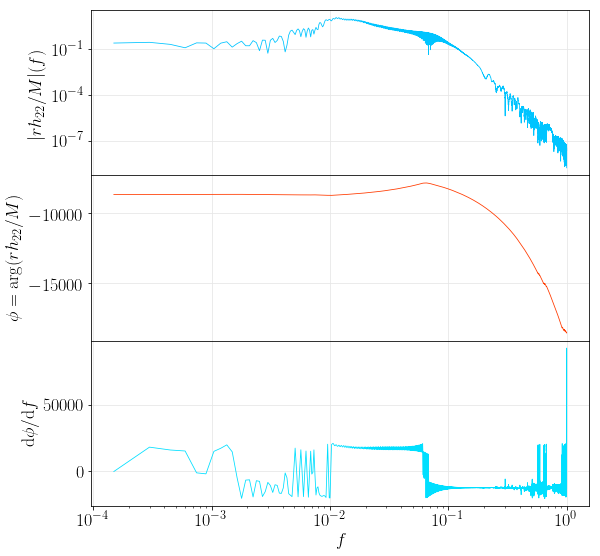

In [252]:
y.lm[2,2]['strain'].plot(domain='freq')

## Inspaect precession dynamics in default simulation frame

### Try to calculate corotating angles

In [240]:

# Options
kind = 'psi4'
domain = 'time'

# Construct dictionary of multipoles using all multipoles available
mp = { (l,m) : ( y.lm[l,m][kind].y if domain in ('t','time') else y.lm[l,m][kind].fd_y ) for l,m in y.lm  }
domain_vals = y.lm[2,2][kind].t if domain in ('t','time') else y.lm[2,2][kind].f

# Calculate corotating angles using low-level function
alpha,beta,gamma = calc_coprecessing_angles( mp, domain_vals )
x,yy,z            = calc_coprecessing_angles( mp, domain_vals, return_xyz=True )


### Plot the angles and the waveform amplitude for reference

(607.20000000000005, 4164.8000000000002)

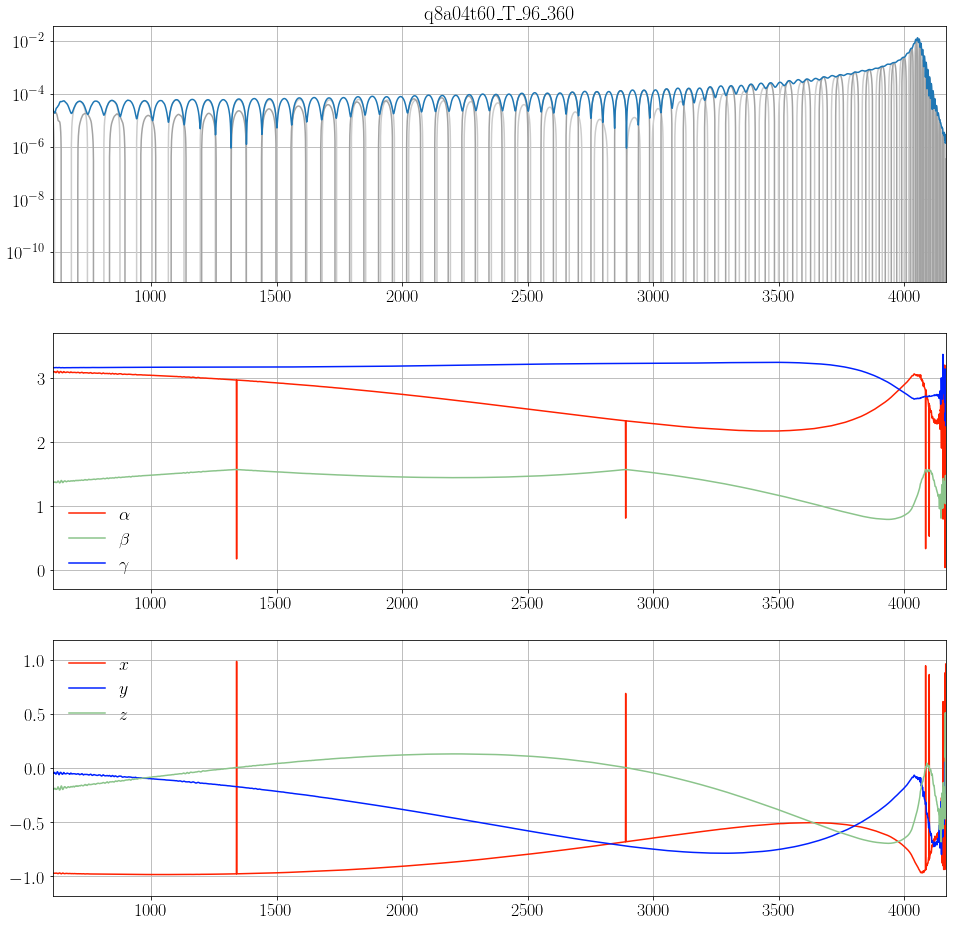

In [241]:

#
fig = figure( figsize=4*figaspect(1) )
clr = rgb(3,jet=True); grey = ones(3)*0.8
lw = 1.5

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#
mask = (domain_vals>=domain_min) & (domain_vals<=domain_max)

#
ax = subplot(3,1,1)
title( y.simname.replace('_','\_') )
if domain in ('t','time'):
    plot( domain_vals, y.lm[2,2][kind].plus, color=grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].cross, color=0.8*grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].amp, linewidth = lw )
    yscale('log',nonposy='clip')
else:
    plot( domain_vals, y.lm[2,2][kind].fd_amp, linewidth = lw )
    xscale('log'); yscale('log')
    ylim( lim(y.lm[2,2][kind].fd_amp[mask]) )
grid()

#
subplot(3,1,2,sharex=ax)
reshift = lambda V: V - V[mask][0] + mod(V[mask][0],2*pi)
plot( domain_vals, reshift(alpha), color = clr[0], linewidth = lw, label=r'$\alpha$' )
plot( domain_vals, reshift(beta),  color = clr[1], linewidth = lw, label=r'$\beta$' )
plot( domain_vals, reshift(gamma), color = clr[2], linewidth = lw, label=r'$\gamma$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([reshift(alpha)[mask],reshift(beta)[mask],reshift(gamma)[mask]]), dilate=0.1 ) )
grid()

#
subplot(3,1,3,sharex=ax)
plot( domain_vals, x, color = clr[0], linewidth = lw, label=r'$x$' )
plot( domain_vals, yy,  color = clr[2], linewidth = lw, label=r'$y$' )
plot( domain_vals, z, color = clr[1], linewidth = lw, label=r'$z$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([x[mask],yy[mask],z[mask]]), dilate=0.1 ) )
grid()

#
ax.set_xlim( [ domain_min, domain_max ] )
# ax.set_xlim( [ 1600,1650 ] )

### Plot XY Projection of angles in polar coordinates

>> -0.94786779225 0.0010573929144 -0.318662094288
[-0.370491  0.       -0.135005] [-0.147502  0.274302 -0.053749] [-0.517993  0.274302 -0.188754]
**  -0.947774684882 -0.0226977884527 -0.318131980625


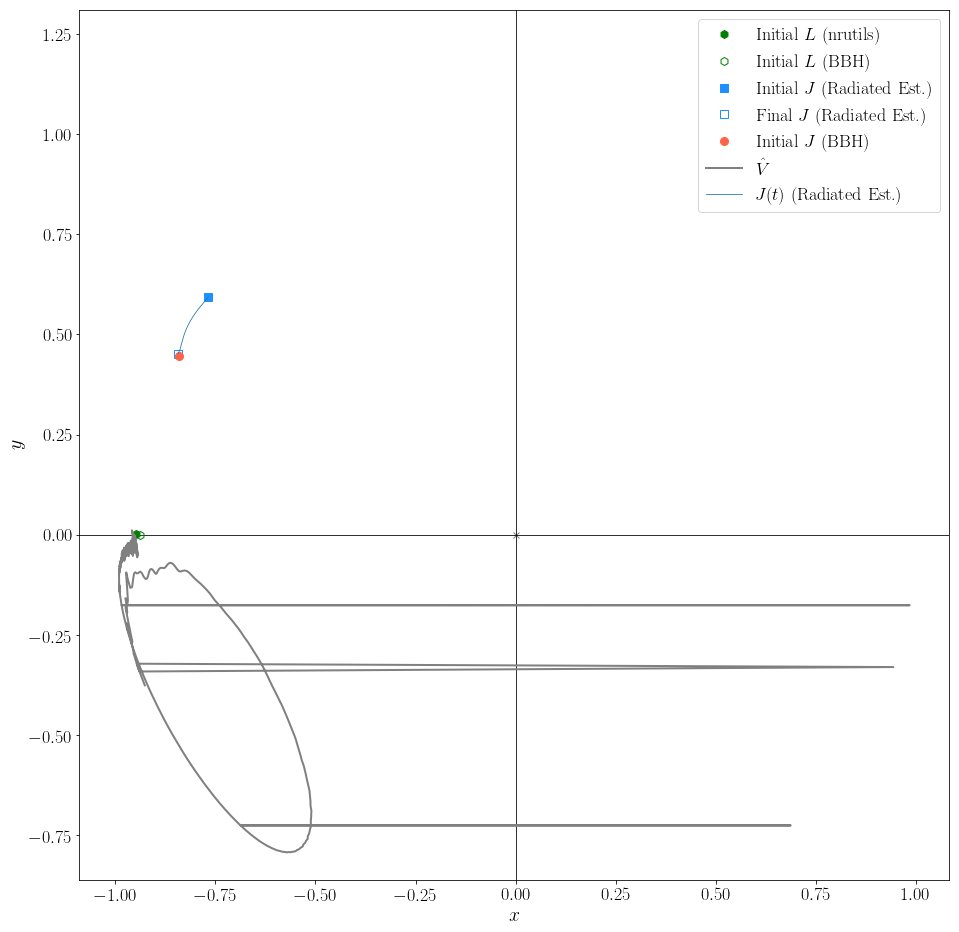

In [242]:

#
fig = figure( figsize=4*figaspect(1) )
color = rgb(3)

#
y.__calc_radiated_quantities__()
k = 0
jx,jy,jz = y.remnant['J'][k] / linalg.norm( y.remnant['J'][k] )
jfx,jfy,jfz = y.remnant['J'][-1] / linalg.norm( y.remnant['J'][-1] )

#
lx,ly,lz = (y.L1+y.L2)/linalg.norm( y.L1+y.L2 )
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
lx_bbh,ly_bbh,lz_bbh = L/linalg.norm(L)
print '>>',lx,ly,lz 

#
S1 = array([ y.raw_metadata.initial_bh_spin2x, y.raw_metadata.initial_bh_spin2y, y.raw_metadata.initial_bh_spin2z])
S2 = array([ y.raw_metadata.initial_bh_spin1x, y.raw_metadata.initial_bh_spin1y, y.raw_metadata.initial_bh_spin1z])
S = S1+S2
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
bbh_jx,bbh_jy,bbh_jz = (L+S)/linalg.norm( L+S )

print L,S,L+S

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#
# mask = (domain_vals>=domain_min) & (domain_vals<=2030)
# mask = smoothest_part(alpha, smoothness_radius=120, smoothness_stepsize=3, smooth_length=3, smoothness_tolerance=2, unsigned=True)
mask = y.remnant['mask'][2:]

#
axhline(0,color='k')
axvline(0,color='k')

#
plot( lx,ly, 'h', color='green', label='Initial $L$ (nrutils)', ms=8 )
plot( lx_bbh,ly_bbh, 'h', color='green', label='Initial $L$ (BBH)', ms=8, mfc='none' )

#
plot( jx,jy, 's', color='dodgerblue', label='Initial $J$ (Radiated Est.)', ms=8 )
plot( jfx,jfy, 's', mfc='none', color='dodgerblue', label='Final $J$ (Radiated Est.)', ms=8 )

#
plot( bbh_jx,bbh_jy, 'o', color='tomato', label='Initial $J$ (BBH)', ms=8 )

#
plot( 0,0, 'xk', alpha=0.5 )

#
plot( x[mask],yy[mask], lw=2, color='grey', label='$\hat{V}$' )
print '** ',x[mask][0],yy[mask][0],z[mask][0]

#
J = y.remnant['J']
for k in range(J.shape[0]):
    J[k,:] /= linalg.norm(J[k,:])
plot( J[:,0],J[:,1], label='$J(t)$ (Radiated Est.)' )

axis('square');

#
xlabel('$x$')
ylabel('$y$');

#
legend( loc=1, frameon=True )


## Inspect simulation dynamics when J_initial || z; that is, perform rotations to rotate quantities accordingly.

In [243]:
# Calculate the initial J from the radiation
k = 0
J = y.remnant['J'][k] / linalg.norm( y.remnant['J'][k] )

# Calculate angles required to rotate J into z direction
Jx,Jy,Jz = J
# NOTE that the minus signs here signify that we are totating the opposite dirction in which the angles are computed
beta = -arccos( Jz/linalg.norm(J) )
gamma = -arctan2( Jy,Jx )

# Define zeta (i.e. -alpha) such that L is along the y-z plane
L = (y.L1 + y.L2) / linalg.norm(y.L1 + y.L2) 
L_ = rotate3 ( L, 0, beta, gamma )
zeta = arctan2( L_[1], L_[0] )

#
alpha = -zeta

#
angles = [alpha,beta,gamma]

# 
alert( 'Rotating J along the z direction should yield [0,0,1] below:' )
print 'J = ',J
print '  = ',rotate3( J, alpha,beta,gamma)
print 'L = ',L
print '  = ',rotate3( L, alpha,beta,gamma)

# Perform rotation
g = y.__rotate_frame_at_all_times__(angles)

(notebook)>> Rotating J along the z direction should yield [0,0,1] below:
J =  [-0.76777503  0.59362649 -0.24109976]
  =  [  7.62533300e-17  -1.41254465e-17   1.00000000e+00]
L =  [-0.94786779  0.00105739 -0.31866209]
  =  [  5.92994818e-01  -3.71270975e-17   8.05206275e-01]
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated.


In [244]:
# Options
kind = 'psi4'
domain = 'time'

# Construct dictionary of multipoles using all multipoles available
mp = { (l,m) : ( g[l,m][kind].y if domain in ('t','time') else g[l,m][kind].fd_y ) for l,m in y.lm  }
domain_vals = g[2,2][kind].t if domain in ('t','time') else g[2,2][kind].f

# Calculate corotating angles using low-level function
alpha,beta,gamma = calc_coprecessing_angles( mp, domain_vals )
x,yy,z            = calc_coprecessing_angles( mp, domain_vals, return_xyz=True )

(607.20000000000005, 4164.8000000000002)

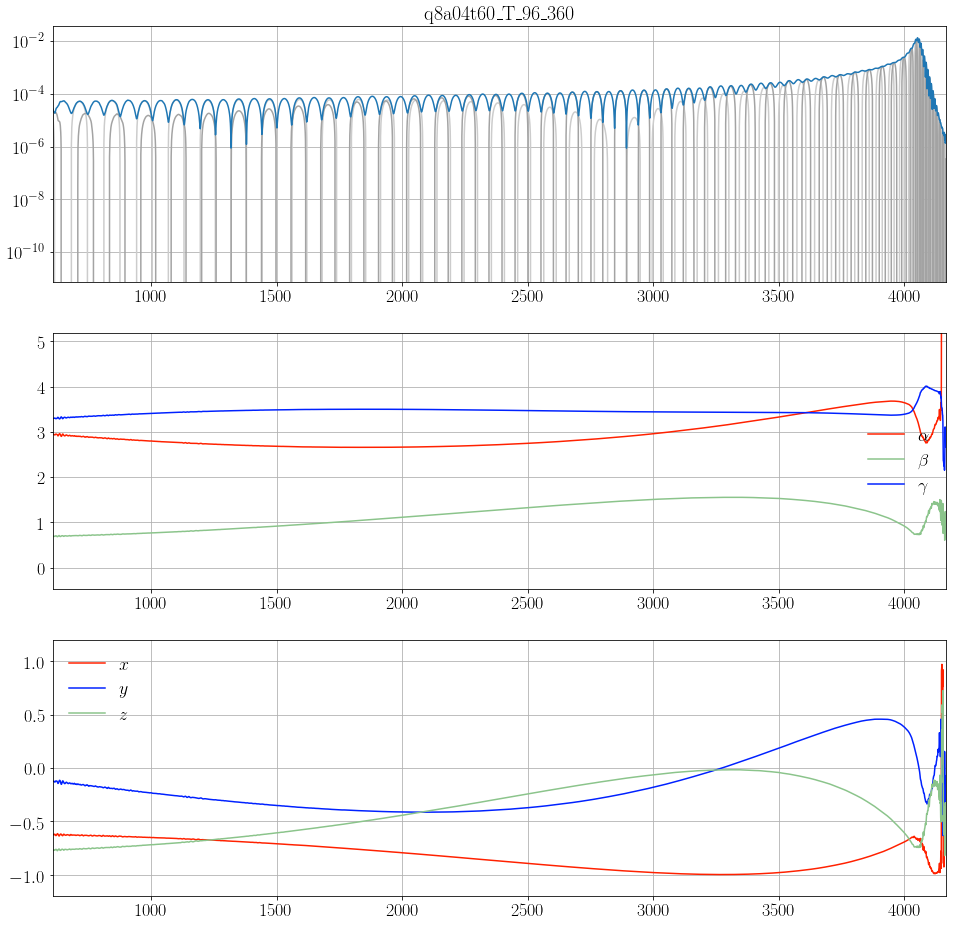

In [245]:

#
fig = figure( figsize=4*figaspect(1) )
clr = rgb(3,jet=True); grey = ones(3)*0.8
lw = 1.5

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#  NOTE that this is defined in gwylm.__calc_radiated_quantities__() and that g.remnant['mask'] == g.radiated['mask']
mask = g.remnant['mask']

#
ax = subplot(3,1,1)
title( y.simname.replace('_','\_') )
if domain in ('t','time'):
    plot( domain_vals, y.lm[2,2][kind].plus, color=grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].cross, color=0.8*grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].amp, linewidth = lw )
    yscale('log',nonposy='clip')
else:
    plot( domain_vals, y.lm[2,2][kind].fd_amp, linewidth = lw )
    xscale('log'); yscale('log')
    ylim( lim(y.lm[2,2][kind].fd_amp[mask]) )
grid()

#
subplot(3,1,2,sharex=ax)
reshift = lambda V: V - V[mask][0] + mod(V[mask][0],2*pi)
plot( domain_vals, reshift(alpha), color = clr[0], linewidth = lw, label=r'$\alpha$' )
plot( domain_vals, reshift(beta),  color = clr[1], linewidth = lw, label=r'$\beta$' )
plot( domain_vals, reshift(gamma), color = clr[2], linewidth = lw, label=r'$\gamma$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([reshift(alpha)[mask],reshift(beta)[mask],reshift(gamma)[mask]]), dilate=0.1 ) )
grid()

#
subplot(3,1,3,sharex=ax)
plot( domain_vals, x, color = clr[0], linewidth = lw, label=r'$x$' )
plot( domain_vals, yy,  color = clr[2], linewidth = lw, label=r'$y$' )
plot( domain_vals, z, color = clr[1], linewidth = lw, label=r'$z$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([x[mask],yy[mask],z[mask]]), dilate=0.1 ) )
grid()

#
ax.set_xlim( [ domain_min, domain_max ] )

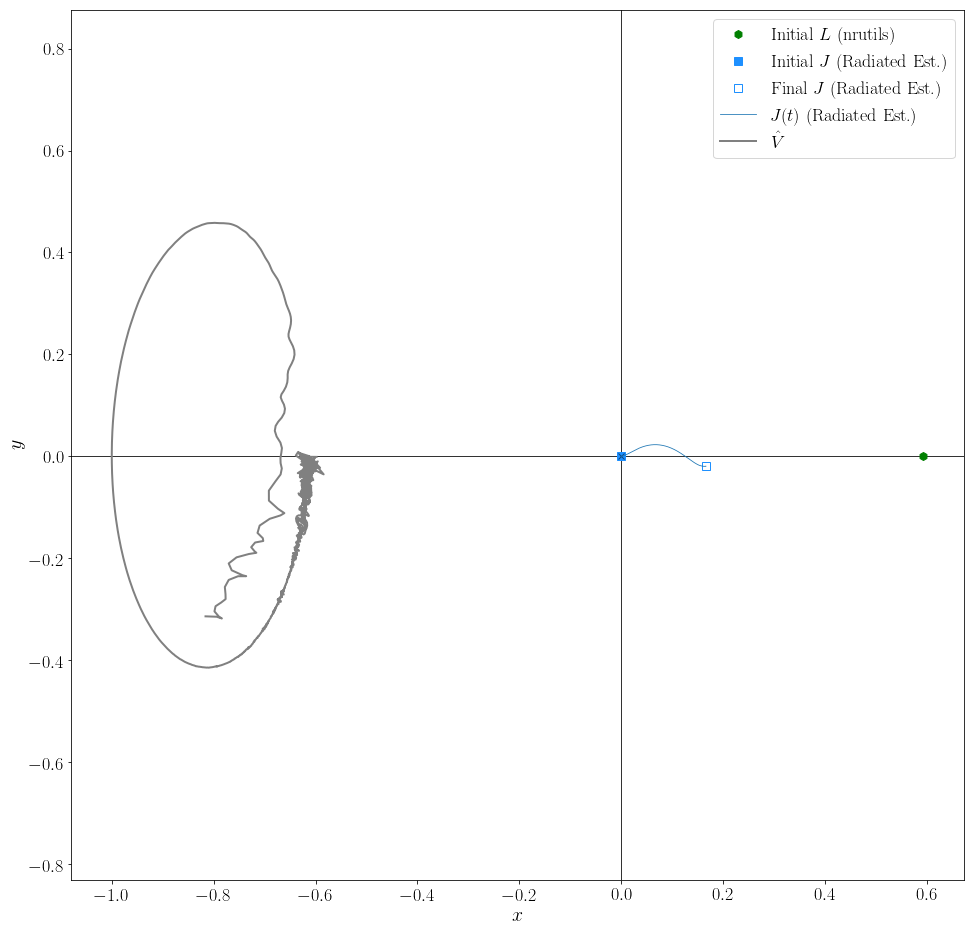

In [246]:

#
fig = figure( figsize=4*figaspect(1) )
color = rgb(3)

#
g.__calc_radiated_quantities__(use_mask=False)
k = 0
jx,jy,jz = g.remnant['J'][k] / linalg.norm( g.remnant['J'][k] )
jfx,jfy,jfz = g.remnant['J'][-1] / linalg.norm( g.remnant['J'][-1] )

#
# mask = smoothest_part(alpha, smoothness_radius=80, smoothness_stepsize=3, smooth_length=3, smoothness_tolerance=0.5, unsigned=True)
# mask = g.remnant['mask'][1:]
mask = arange( g.startindex+1, g.endindex_by_frequency+1 )

#
axhline(0,color='k')
axvline(0,color='k')

#
lx,ly,lz = (g.L1+g.L2)/linalg.norm( g.L1+g.L2 )#
plot( lx,ly, 'h', color='green', label='Initial $L$ (nrutils)', ms=8 )

#
plot( jx,jy, 's', color='dodgerblue', label='Initial $J$ (Radiated Est.)', ms=8 )
plot( jfx,jfy, 's', mfc='none', color='dodgerblue', label='Final $J$ (Radiated Est.)', ms=8 )

#
plot( 0,0, 'xk', alpha=0.5 )

#
J = g.remnant['J']
absJ = zeros_like(J)
for k in range(J.shape[0]):
    J[k,:] /= linalg.norm(J[k,:])
    absJ[k] = J[k]
plot( J[:,0],J[:,1], label='$J(t)$ (Radiated Est.)' )

#
plot( x[mask],yy[mask], lw=2, color='grey', label='$\hat{V}$' )

axis('equal');

#
xlabel('$x$')
ylabel('$y$');

#
legend( loc=1, frameon=True )

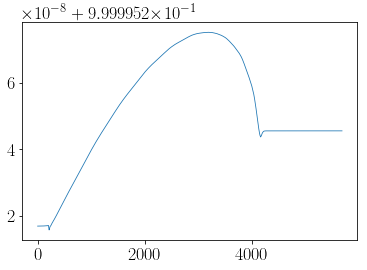

In [99]:
plot(absJ[:,-1])

In [100]:

#
v = array([1,2,3])

#
N = 8
alpha = linspace(0,pi,N)
beta = 2*alpha
gamma = 3*alpha

#
a = rotate3( v, alpha, beta, gamma )

#
print a
print a.shape

#
b = []
k = 0
for k in range(len(alpha)):
    print '>> ',rotate3( v, alpha[k], beta[k], gamma[k] )
    b.append( rotate3( v, alpha[k], beta[k], gamma[k] ) )

#
b = array(b)
print b 


[[ 1.          2.          3.        ]
 [ 0.52679411  1.82973823  3.2209542 ]
 [ 3.13855417  1.7414342   1.05682763]
 [ 2.07909912 -0.00826585 -3.11083245]
 [ 0.27464884 -3.29367188 -1.75393658]
 [ 0.08014356 -3.68647607 -0.63519384]
 [ 3.10363011 -2.08275862  0.17203686]
 [ 1.          2.          3.        ]]
(8, 3)
>>  [ 1.  2.  3.]
>>  [ 0.52679411  1.82973823  3.2209542 ]
>>  [ 3.13855417  1.7414342   1.05682763]
>>  [ 2.07909912 -0.00826585 -3.11083245]
>>  [ 0.27464884 -3.29367188 -1.75393658]
>>  [ 0.08014356 -3.68647607 -0.63519384]
>>  [ 3.10363011 -2.08275862  0.17203686]
>>  [ 1.  2.  3.]
[[ 1.          2.          3.        ]
 [ 0.52679411  1.82973823  3.2209542 ]
 [ 3.13855417  1.7414342   1.05682763]
 [ 2.07909912 -0.00826585 -3.11083245]
 [ 0.27464884 -3.29367188 -1.75393658]
 [ 0.08014356 -3.68647607 -0.63519384]
 [ 3.10363011 -2.08275862  0.17203686]
 [ 1.          2.          3.        ]]


In [14]:
print b.T[0]

[ 1.          0.52679411  3.13855417  2.07909912  0.27464884  0.08014356
  3.10363011  1.        ]
